# Assignment 3: Solving Helmholtz differental equations 

**Deadline**: 25.01.23

**Submission**: Submit a PDF export of the completed notebook as well as the ipynb file. 



In this assignment, we will build a Physics Informed Neural Networks (PINN) that can solve Helmholtz equation. The Helmholtz equation is a Partial Differential Equation (PDE) that arises to solve physical problems such as wave propogation. Its linear version takes the form of the  partial differential equation $∇^{2}h = -k^{2}h$, where $∇^{2}$ is the Laplace operator, $k$ is the wave number and $h$ is the function, where $h(x, z) = u(x, z) + iv(x, z)$


We will explore how leveraging data helps us to solve physics problems, in particular Helmholtz equation. We will use DNNs architectures and the boundary and initial conditions in the loss function,
a starter code is given to help with data processing and make it a bit easier.

In this assignment you have a chance to build your neural network all by yourself.

**Note:** you may modify the starter code as you see fit, including changing the signatures of functions and adding/removing helper functions. However, please make sure that you properly explain what you are doing and why.

In [36]:
import numpy as np
import torch
import torch.autograd as autograd         
from torch import Tensor                  

!pip install pyDOE
from pyDOE import lhs 
import torch.nn as nn                    
import torch.optim as optim         
import matplotlib.pyplot as plt
import time

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Question 1. Data (15%)

<!-- With any machine learning problem, the first thing that we would want to do
is to get an intuitive understanding of what our data looks like. Download the file
`??` from the course page on Moodle and upload it to Google Drive.
Then, mount Google Drive from your Google Colab notebook: -->
In this part you will generate a 2-D input dataset with a collection points that enforce the initial and boundary conditions.
Where the computational domain is $x ∈ [-1,1]$ and $z ∈ [0, 1]$.

We want to generate an input datasets which contain two aperture

Each of the datasets have 256 **equally** spaced spatial points to enforce the initial condition. 


In [37]:
"""
X with size (260, 260) and the size of each row is (256,) where each row is from -1 to 1 (i.e x0)
Z with size (260, 260) and the size of each column is (256,) where each column is from 0 to 1 (i.e. z0)
"""
initial_points = 256
half_aperture = 0.2
x0 = np.linspace(-1,1,initial_points)  # 256 points between -1 and 1 (260,)
z0 = np.linspace(0,1,initial_points)  # 256 points between 0 and 1 (260,)

X, Z = np.meshgrid(x0, z0) # (256, 256)

### Part (a) -- 7%

Generate the initial condition at $z=0$ i.e. $\mathcal{u}(\mathcal{x},\mathcal{z}=0) = rect(\frac{z}{2 * HalfAperture})$.

Where the middle of each rectangular needs to be at the middle of each half.

**Note:** the initial condition needs to be **only** at the first place of the first dimension of the array 


In [38]:
Exact_u = np.zeros((initial_points, initial_points))
Exact_v = np.zeros((initial_points, initial_points))

In [39]:
from matplotlib.legend_handler import Rectangle
# Your code goes here 
middle1 = -0.5
middle2 = 0.5
Exact_u[:,0] = np.heaviside(x0-middle1+half_aperture,0.5) - np.heaviside(x0-middle1-half_aperture,0.5) + np.heaviside(x0-middle2+half_aperture,0.5) - np.heaviside(x0-middle2-half_aperture,0.5)
print(Exact_u[10,0])
print(Exact_u[100,1])

0.0
0.0


Text(0.5, 1.0, 'Initial condition')

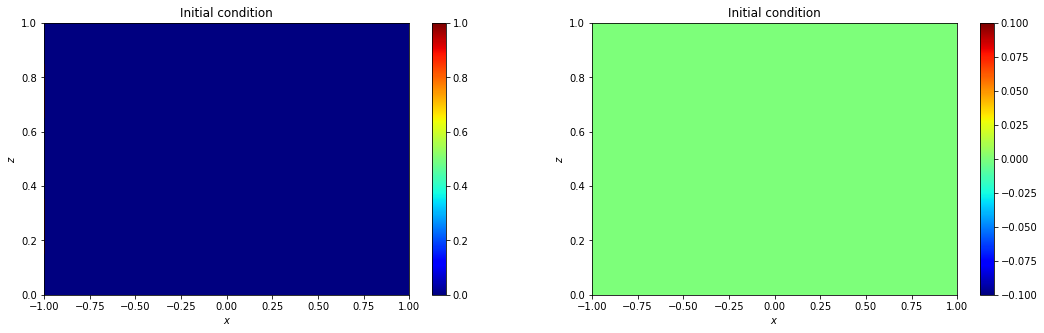

In [42]:
plt.figure(1, figsize=(18, 5))
plt.subplot(1, 2, 1)
plt.pcolor(x0, z0, Exact_u, cmap='jet')
plt.colorbar()
plt.xlabel(r'$x$', fontsize=10)
plt.ylabel(r'$z$', fontsize=10)
plt.title('Initial condition')
plt.subplot(1, 2, 2)
plt.pcolor(x0, z0, Exact_v, cmap='jet')
plt.colorbar()
plt.xlabel(r'$x$', fontsize=10)
plt.ylabel(r'$z$', fontsize=10)
plt.title('Initial condition')

In [43]:
U0 = Exact_u.copy()
V0 = Exact_v.copy()

u_true = U0.flatten('F')[:,None] 
v_true = V0.flatten('F')[:, None]

We prepare the test data to compare against the solution produced by the PINN.

In [44]:
X_u_test = np.hstack((X.flatten(order='F')[:,None], Z.flatten(order='F')[:,None]))
X_v_test = np.hstack((X.flatten(order='F')[:,None], Z.flatten(order='F')[:,None]))

# Domain bounds
lb = np.array([-1, 0]) #lower bound of x and z domains
ub = np.array([1, 1])  #upper bound of x and z domains

### Part (b) -- 8%

Now we want to generte a quasi-random point set object that produces points using Latin Hypercube sampling (LHS). 

Latin square is an $n \times n$ array filled with $n$ different symbols, each occurring exactly once in each row and exactly once in each column. A Latin hypercube is the generalization of this concept to an arbitrary number of dimensions where each sample is the **only** one in each axis of the hyperplane containing it.


You can start by reading [API documentation here](https://pythonhosted.org/pyDOE/randomized.html#latin-hypercube).


The function `generate_training_data` outputs the training data and the ground truth data, the output data is not normalized. 

In this part you will need to first to complete `X_f` in order to generate LHS for collection points. Second, reate a function `normalize_data` where the input is the data and the output is the normalized data. 

**Note:** You can modify the `generate_training_data` function so the output will be normalized data.


In [ ]:
def generate_training_data(N_u, N_f, X, Z, usol):
    """
    X_f contains the samples inside to boundary condition
    X_f shape: (N_f, 2)
    Where (N_f, 0) and (N_f, 1) are the samples that maintain  x and z 
    boundary condition respectivly 
    """
    # Your code goes here   
     
    '''Collocation Points'''
    X_u_train = ... # TODO choose indices from  set 'idx' (x,t)
    u_train = ... # TODO

    # Latin Hypercube sampling for collocation points 

    X_f = ... # TODO
    X_f_train = np.vstack((X_f, X_u_train)) # append training points to collocation points 
    
    return X_f_train, X_u_train, u_train 

Generate the training data, you can modify `N_f` and `N_u` in order to get better results.

**Remember the model inputs type need to be Torch and not numpy**

In [ ]:
N_u = initial_points
N_f = 10000

# Training data
X_f_u_train, X_u_train, u_train = generate_training_data(N_u, N_f, X, Z, U0)
X_f_v_train, X_v_train, v_train = generate_training_data(N_u, N_f, X, Z, V0)

## Question 2. Model architecture (30%)

**Note:** You can can train the the same model on $u(x, z)$ and $v(x, z)$ seperatly and combin the output of the two models or you can do it directly on $h(x, z)$. Where $|h(x, z)| = \sqrt{u(x, z)^{2} + v(x, z)^{2}}$.


### Part (a) -- 15%
Implement a PINN model architecture in PyTorch called `PINN` that will take the data points and will solve the Helmholtz equation.

It is recommended that the model will contain 9 hidden layers, start with this number and play with it. In assition, you can play with the number of in/out features of the hidden layers in order to get good results.

We build the model in PyTorch. Since PyTorch uses automatic
differentiation, we only need to write the *forward pass* of our
model. 


In [ ]:
class PINN(nn.Module):
  def __init__(self,layers):
    super().__init__() #call __init__ from parent class 
      # TODO: complete this method

  # TODO: complete this class



**Please show the model scheme here:**

### Part (b) -- 15%

In this part you will build the loss function which takes as input the model parameters $X$ and $Z$, the initial and boundary conditions $X0$, $Z0$ and $H0$ and return the loss with respect to the learnable parameters.

The model is trained by enforcing that given an input the output of the network fulfills the Helmholtz's equation, the boundary conditions, and the initial condition. 

**Remember:** the loss function of the model needs to be `nn.MSELoss()`, use it when you compute the loss.

In [ ]:
def mse_loss_f():
                
  # Write your code here
                
  return ...

In [ ]:
def mse_loss_h():
                
  # Write your code here
                
  return ...

In [ ]:
def mse_loss():
  # Write your code here
        
  return ...

## Question 3. Training (40%)

Now, we will write the functions required to train the PyTorch model using the `Adam optimizer` and the `mse loss` Q2-part (b). You can modify the optimizer parameters.

Keep in mind that our task is to solve the Helmholtz equation.

### Part (a) -- 30%

Complete the function `train_model`, and use it to train your PyTorch MLP model.

**Note:** You can change the `Adam` optimizer to whatever optimizer you want which gives a good results. 


In [ ]:
def train_model(model, ...):
  start_time = time.time()
  print('Training start time: %.2f' % (start_time))
  
  optimizer = optim.Adam(model.parameters(), lr=0.05, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
  # Write your code here
  
  elapsed = time.time() - start_time
  print('Training end time: %.2f, Training time: %.2f' % (time.time(), elapsed))
  return ...




### Part (b) -- 10%
Complete the `plot_learning_curve` function and plot the learning curve, include your plot in your PDF submission.

In [ ]:
def plot_learning_curve():
    """
    Plot the learning curve.
    """
    # Write your code here



## Question 4. Testing (15%)

### Part (a) -- 7%

Complete the function `test` and use it to print the test error of your model, separately for the test set. 

Do this by choosing the model architecture and hyperparameters that produces the best validation loss. 

In [ ]:
def test(model, X_test_tensor):
                
  u_pred = model.forward(X_test_tensor)
        
  error_vec = ...  # TODO: complete this line. It should be relative L2 Norm of the error (Vector)
        
  u_pred = np.reshape(u_pred.detach().numpy(), (256,256), order='F') 
        
  return ... # TODO: complete what the function should return

### Part (b) -- 8%

We want to visualize how good your model is. Therefore, display the initial and boundary conditions data and the predicted data from the model output.


In [ ]:
# TODO: your code goes here

**Discuss your results:**
